# Notes

- INPUT: Latitude, Longitude, Date, Time
<br><br>
- Train Random Forest Regressor and check the prediction
- Create a time-series network
<br><br>
- OUTPUT: CO, NO, NO2, PM2.5, PM10

### Импортирование нужных библиотек

In [1]:
# Import necessary packages
# Define constant folder paths

import datetime
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from prophet import Prophet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

DATA_FOLDER = '../data'
RAW_DATA_FOLDER = os.path.join(DATA_FOLDER, '01_raw')
PROCESSED_DATA_FOLDER = os.path.join(DATA_FOLDER, '02_processed')
GRAPHS_FOLDER = os.path.join(DATA_FOLDER, '03_graphs')
RESULTS_FOLDER = os.path.join(DATA_FOLDER, '04_results')
STATIONS_DATA_PATH = os.path.join(RAW_DATA_FOLDER, "01_данные_станций")
STATIONS_COORDINATES_PATH = os.path.join(RAW_DATA_FOLDER, "02_координаты_станций.csv")
WIND_DATA_PATH = os.path.join(RAW_DATA_FOLDER, "03_Высотный_пункт_253_м_ветер.xls")
SODAR_DATA_PATH = os.path.join(RAW_DATA_FOLDER, "04_данные_профилемера")

ALL_COLUMNS = [
    'Дата и время',
#     'Год',
#     'Месяц',
#     'День',
#     'Час',
#     'Минута',
    'Станция',
    'Широта',
    'Долгота',
    'Температура',
    'Скорость ветра',
    'Направление ветра',
    'Давление',
    'Влажность',
    'Осадки',
    'CO',
    'NO',
    'NO2',
    'PM2.5',
    'PM10'
]

FEATURE_COLUMNS = ['Температура', 'Скорость ветра', 'Направление ветра', 'Давление', 'Влажность', 'Осадки']

TARGET_COLUMNS = ['CO', 'NO', 'NO2', 'PM2.5', 'PM10']

STATION_NAMES = [
    'Бутлерова',
    'Академика Анохина',
    'Останкино',
    'Марьино',
    'Коптевский бул',
    'Глебовская',
    'Туристская',
    'Пролетарский проспект',
    'Спиридоновка',
    'Шаболовка'
]

Importing plotly failed. Interactive plots will not work.


### Определение функции для предварительной обработки данных

In [2]:
def strip_cols(df):
    for col in df.columns:
        df.rename(columns={col: col.strip()})
        
    return df

def strip_rows(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: x.strip())
    
    return df

def correct_cols(df):
    if 'PM25' in df.columns:
        df.rename(columns={'PM25': 'PM2.5'}, inplace=True)
        
    return df

def add_missing_cols(df):
    miss_cols = ['PM2.5', 'PM10']
    
    for col in miss_cols:
        if col not in df.columns:
            df[col] = np.nan
            
    return df

def drop_empty_cols(df):
    df.dropna(axis=1, how='all', inplace=True)
            
    return df

def drop_columns_check(df, cols):
    temp_df = df.copy()
    
    for col in cols:
        if col in df.columns:
            temp_df.drop(columns=[col], inplace=True)
    
    return temp_df

def remove_outlier_rows(df, station_name):
    if station_name == 'Спиридоновка':
        df.loc[df['Дата и время'] == datetime.datetime(2020, 11, 24, 13, 20)] = [datetime.datetime(2020, 11, 24, 13, 20)] + [-1] * (len(df.columns) - 1)
    
    return df

def rename_cols(df):
    df.rename(
        columns={
            '-T-': 'Температура', 
            '| V |': 'Скорость ветра', 
            '_V_': 'Направление ветра'
        }, 
        inplace=True
    )
    
    return df

def reformat_date_col(df, date_format='%d/%m/%Y %H:%M'):
    df['Дата и время'] = pd.to_datetime(df['Дата и время'], format=date_format)
    
    return df

def add_date_cols(df):
    df['Год'] = df['Дата и время'].dt.year
    df['Месяц'] = df['Дата и время'].dt.month
    df['День'] = df['Дата и время'].dt.day
    df['Час'] = df['Дата и время'].dt.hour
    df['Минута'] = df['Дата и время'].dt.minute
    df.drop(columns=['Дата и время'], inplace=True)
    
    return df

def add_station_name(df, station_name):
    df['Станция'] = station_name
    
    return df

def read_locations_file():
    locations_df = pd.read_csv(STATIONS_COORDINATES_PATH, delimiter=';', index_col=None)
    locations_df = locations_df.T.reset_index().T
    locations_df.index = pd.RangeIndex(start=0, stop=10)
    locations_df.columns = ['Станция', 'Широта', 'Долгота']
    locations_df = strip_cols(locations_df)
    locations_df = strip_rows(locations_df, 'Станция')
    
    return locations_df

def add_locations_cols(df):
    locations_df = read_locations_file()
    df[['Широта', 'Долгота']] = locations_df.loc[locations_df['Станция'] == df['Станция'][0]][['Широта', 'Долгота']].values[0]
    
    return df

def fill_na_cols(df, cols, value):
    df[cols] = df[cols].fillna(value)
    
    return df

def interpolate_na_cols(df, cols):
    df[cols].interpolate(method='polynomial', order=5)
    
    return df

def sort_by_date(df):
    df.sort_values(['Дата и время'], inplace=True)
    
    return df

def clip_cols(df):
    df['Скорость ветра'] = np.clip(df['Скорость ветра'], 0, np.max(df['Скорость ветра']))
    df['Направление ветра'] = np.clip(df['Направление ветра'], 0, 360)
    df['Давление'] = np.clip(df['Давление'], 700, 830)
    df['Влажность'] = np.clip(df['Влажность'], 0, 100)
    df['Осадки'] = np.clip(df['Осадки'], 0, np.max(df['Осадки']))
    
    return df

def preprocess_df(df, station_name):        
    df = strip_cols(df)
    df = correct_cols(df)
    df = drop_empty_cols(df)
    df = remove_outlier_rows(df, station_name)
    df = add_missing_cols(df)
    df = rename_cols(df)
    df = reformat_date_col(df)
    df = add_station_name(df, station_name)
    df = add_locations_cols(df)
    df = interpolate_na_cols(df, FEATURE_COLUMNS)
    df = clip_cols(df)
    
    df = df[ALL_COLUMNS]
    
    return df

### Работа с отсутствующими значениями

In [3]:
def get_individual_dfs():
    dfs = []
    
    for files in os.listdir(STATIONS_DATA_PATH):
        _, ext = os.path.splitext(files)

        if ext == '.xlsx':
            station_name = ' '.join(files.split('_')[:-1])
            file_path = os.path.join(STATIONS_DATA_PATH, files)
            temp_df = pd.read_excel(file_path, skiprows=[1])
            temp_df = preprocess_df(temp_df, station_name)
            dfs.append(temp_df)
            
    return dfs

def equate_df_sizes(dfs):
    min_length = 1e9

    for i in range(len(dfs)):
        cur_length = len(dfs[i])
        
        if min_length > cur_length:
            min_length = cur_length
            
    for i in range(len(dfs)):
        cur_length = len(dfs[i])

        if cur_length > min_length:
            dfs[i] = dfs[i].drop(dfs[i].tail(cur_length - min_length).index)
            
    return dfs

def mean_imputation(df, cols):
    mean_temp_values = pd.Series(df.groupby(['Дата и время'])[cols].mean().values)
    
    for station_name in pd.unique(df['Станция']):
        temp_df = df.loc[df['Станция'] == station_name, cols]
        temp_df.fillna(mean_temp_values, inplace=True)
        df.loc[df['Станция'] == station_name, cols] = temp_df
    
    return df

def show_statistics(df):
    print("Среднее значение стандартного отклонения признаков по дате и времени:\n")
    std_values = df.groupby(['Дата и время']).std().mean()
    print(std_values)

def create_single_df(new=False):
    file_path = os.path.join(PROCESSED_DATA_FOLDER, 'combined_data.csv')
    
    if not new:
        df = pd.read_csv(file_path, index_col=0)
        return df
    
    dfs = get_individual_dfs()
    dfs = equate_df_sizes(dfs)
    df = pd.concat(dfs)
    
    show_statistics(df)
    
    for col in FEATURE_COLUMNS:
        df = mean_imputation(df, col)
    
    df.to_csv(file_path)
    
    return df

def save_separate_dfs_by_station(df):
    for station_name in pd.unique(df['Станция']):
        temp_df = df.loc[df['Станция'] == station_name]
        temp_df = drop_empty_cols(temp_df)
        temp_df = sort_by_date(temp_df)
        temp_df.to_csv(os.path.join(PROCESSED_DATA_FOLDER, f'{station_name}.csv'))
        
def read_all_dfs():
    dfs = []
    
    for csv_file in os.listdir(PROCESSED_DATA_FOLDER):
        if not csv_file == "combined_data.csv":
            csv_file_path = os.path.join(PROCESSED_DATA_FOLDER, csv_file)
            df = pd.read_csv(csv_file_path, index_col=0)
            dfs.append(df)
        
    return dfs

In [4]:
# df = create_single_df(new=True)
# save_separate_dfs_by_station(df)

In [5]:
def save_feature_plots(dfs, col):
    fig, ax = plt.subplots(10, 1, sharey=True, facecolor='white', figsize=(20, 50))
    
    date_fmt = mdates.DateFormatter('%Y/%m/%d %H:%M')
    
    for i in range(len(dfs)):
        ax[i].xaxis.set_major_formatter(date_fmt)
        x_date = pd.to_datetime(dfs[i]['Дата и время'])
        
        sns.scatterplot(
            x=[x_date[0], x_date[len(dfs[i])-1]], 
            y=[dfs[i][col].values[0], dfs[i][col].values[-1]], 
            color='red',
            s=100,
            zorder=2,
            ax=ax[i]
        )
        
        sns.lineplot(
            x=x_date, 
            y=dfs[i][col].values, 
            color='blue', 
            zorder=1,
            ax=ax[i],
            label=f'{col}'
        )
        
        ax[i].set_title('%s' % dfs[i]['Станция'][0], fontsize=15)
        ax[i].set_ylim([np.min(dfs[i][col].values), np.max(dfs[i][col].values)])
    
    fig.tight_layout()
    fig.savefig(os.path.join(GRAPHS_FOLDER, f'{col}.png'), facecolor=fig.get_facecolor(), edgecolor='none');

In [6]:
# dfs = read_all_dfs()

# for col in FEATURE_COLUMNS:
#     save_feature_plots(dfs, col)

### Тренировка модели Prophet

In [7]:
def read_df(name):
    csv_path = os.path.join(PROCESSED_DATA_FOLDER, name)
    df = pd.read_csv(csv_path, index_col=0)
    df.drop(columns=['Станция', 'Широта', 'Долгота'], inplace=True)
    
    return df

In [8]:
def get_target_cols(df):
    target_cols = {'CO': 0, 'NO': 0, 'NO2': 0, 'PM2.5': 0, 'PM10': 0}
    
    for col in target_cols:
        if col in df.columns:
            target_cols[col] = len(df) - df[col].isna().sum()
            
    target_cols = sorted(target_cols.items(), key=lambda x: x[1], reverse=True)
    target_cols = {k: v for k, v in target_cols}
    
    return target_cols

def create_forecast_dataframe(df, reg_cols, start_date, end_date, freq):
    ds = pd.date_range(
        start=start_date, 
        end=end_date,
        freq=freq
    )[:-1]
    
    forecast_df = pd.DataFrame({'ds': ds})
    
    for col in reg_cols:
        temp_df = df.copy()
        temp_df['y'] = temp_df[col]
        temp_df['ds'] = temp_df['Дата и время']
        temp_df = temp_df[['ds', 'y']]
        
        model = Prophet(
            yearly_seasonality=False,
            weekly_seasonality=False,
            daily_seasonality=False
        )
        
        if col == 'Давление':
            model = model.add_seasonality(
                name='quarterly',
                period=365.25/6,
                fourier_order=25
            )
        else:
            model = model.add_seasonality(
                name='yearly',
                period=365.25,
                fourier_order=25
            )
            
        model.fit(temp_df)
        result = model.predict(forecast_df)
        model.plot(result)
        
        if col != 'Температура':
            result = np.clip(result, 0, np.max(result))
            
        result = result['yhat']
        forecast_df.insert(0, col, result, True)
    
    return forecast_df

def train_model(df, future_df):
    np.random.seed(777)

    target_cols = get_target_cols(df)
    
    temp_df = df.copy()
    temp_df['ds'] = pd.to_datetime(df['Дата и время'])
    temp_df.drop(columns=['Дата и время'], inplace=True)
    temp_df = drop_columns_check(temp_df, target_cols.keys())
        
    cols = FEATURE_COLUMNS.copy()
    
    for k, _ in target_cols.items():
        if k in df.columns:
            temp_df[k] = df[k]  
            temp_df.fillna(temp_df.mean(), inplace=True)
            temp_df['y'] = temp_df[k]
            temp_df.drop(columns=[k], inplace=True)

            model = Prophet(yearly_seasonality=False)

            for col in cols:
                model.add_regressor(col)

            model.fit(temp_df)

            forecast = model.predict(future_df)
            model.plot(forecast)
            plt.tight_layout()
            plt.show();

            y_pred = forecast['yhat'].values.clip(min=0)
            
#             y_true = test['y'].values
#             mae = mean_absolute_error(y_true, y_pred)
            
            plt.subplots(figsize=(15, 10))
#             plt.plot(y_true, label='Actual')
            plt.plot(y_pred, label='Predicted')
            plt.title(f'Predictions on {k}')
            plt.legend()
            plt.tight_layout()
            plt.show();
            
            future_df[k] = y_pred
            temp_df[k] = temp_df['y']
            temp_df.drop(columns=['y'], inplace=True)
            cols.append(k)
            
    return future_df

In [9]:
def make_prediction_file(csv_file):
    df = read_df(csv_file)
    
    print(f"Выявление неподвижности временных рядов в станции {csv_file.split('.')[0]}:\n")

    for col in FEATURE_COLUMNS:
        print(f'P-value for {col}: {adfuller(df.fillna(-1)[col])[1]}')
          
    print('\n')
          
    future = create_forecast_dataframe(
        df=df, 
        reg_cols=FEATURE_COLUMNS, 
        start_date='2021-01-01', 
        end_date='2021-03-01', 
        freq='20T'
    )

    for col in future.set_index('ds').columns:
        _, ax = plt.subplots(figsize=(15, 10))
        plt.title(f'{col}')
        future[col].plot(ax=ax)
        plt.tight_layout()
        plt.show();
          
    forecast = train_model(df, future)
          
    return forecast

In [15]:
def plot_forecast(df, idx):
    ax_idx = 0
    colors=['red', 'blue', 'green', 'black', 'brown']
    target_count = 0
    
    for col in df.columns:
        if col in TARGET_COLUMNS:
            target_count += 1
            
    fig, ax = plt.subplots(target_count, 1, facecolor='white', figsize=(20, 50))
    
    for col in TARGET_COLUMNS:
        if col in df.columns:
            df.set_index('ds')[col].plot(ax=ax[ax_idx], color=colors[ax_idx])
            ax[ax_idx].set_title(f'Станция {STATION_NAMES[idx]}. Значения для {col}', fontsize=20)
            ax[ax_idx].tick_params(axis='both', which='major', labelsize=20)
            ax[ax_idx].tick_params(axis='both', which='minor', labelsize=15)
            ax[ax_idx].set_xlabel('Дата и время', fontsize=20)
            ax_idx += 1
    
    plt.tight_layout()
    fig.savefig(os.path.join(RESULTS_FOLDER, f'{STATION_NAMES[idx]}.png'), facecolor=fig.get_facecolor(), edgecolor='none');

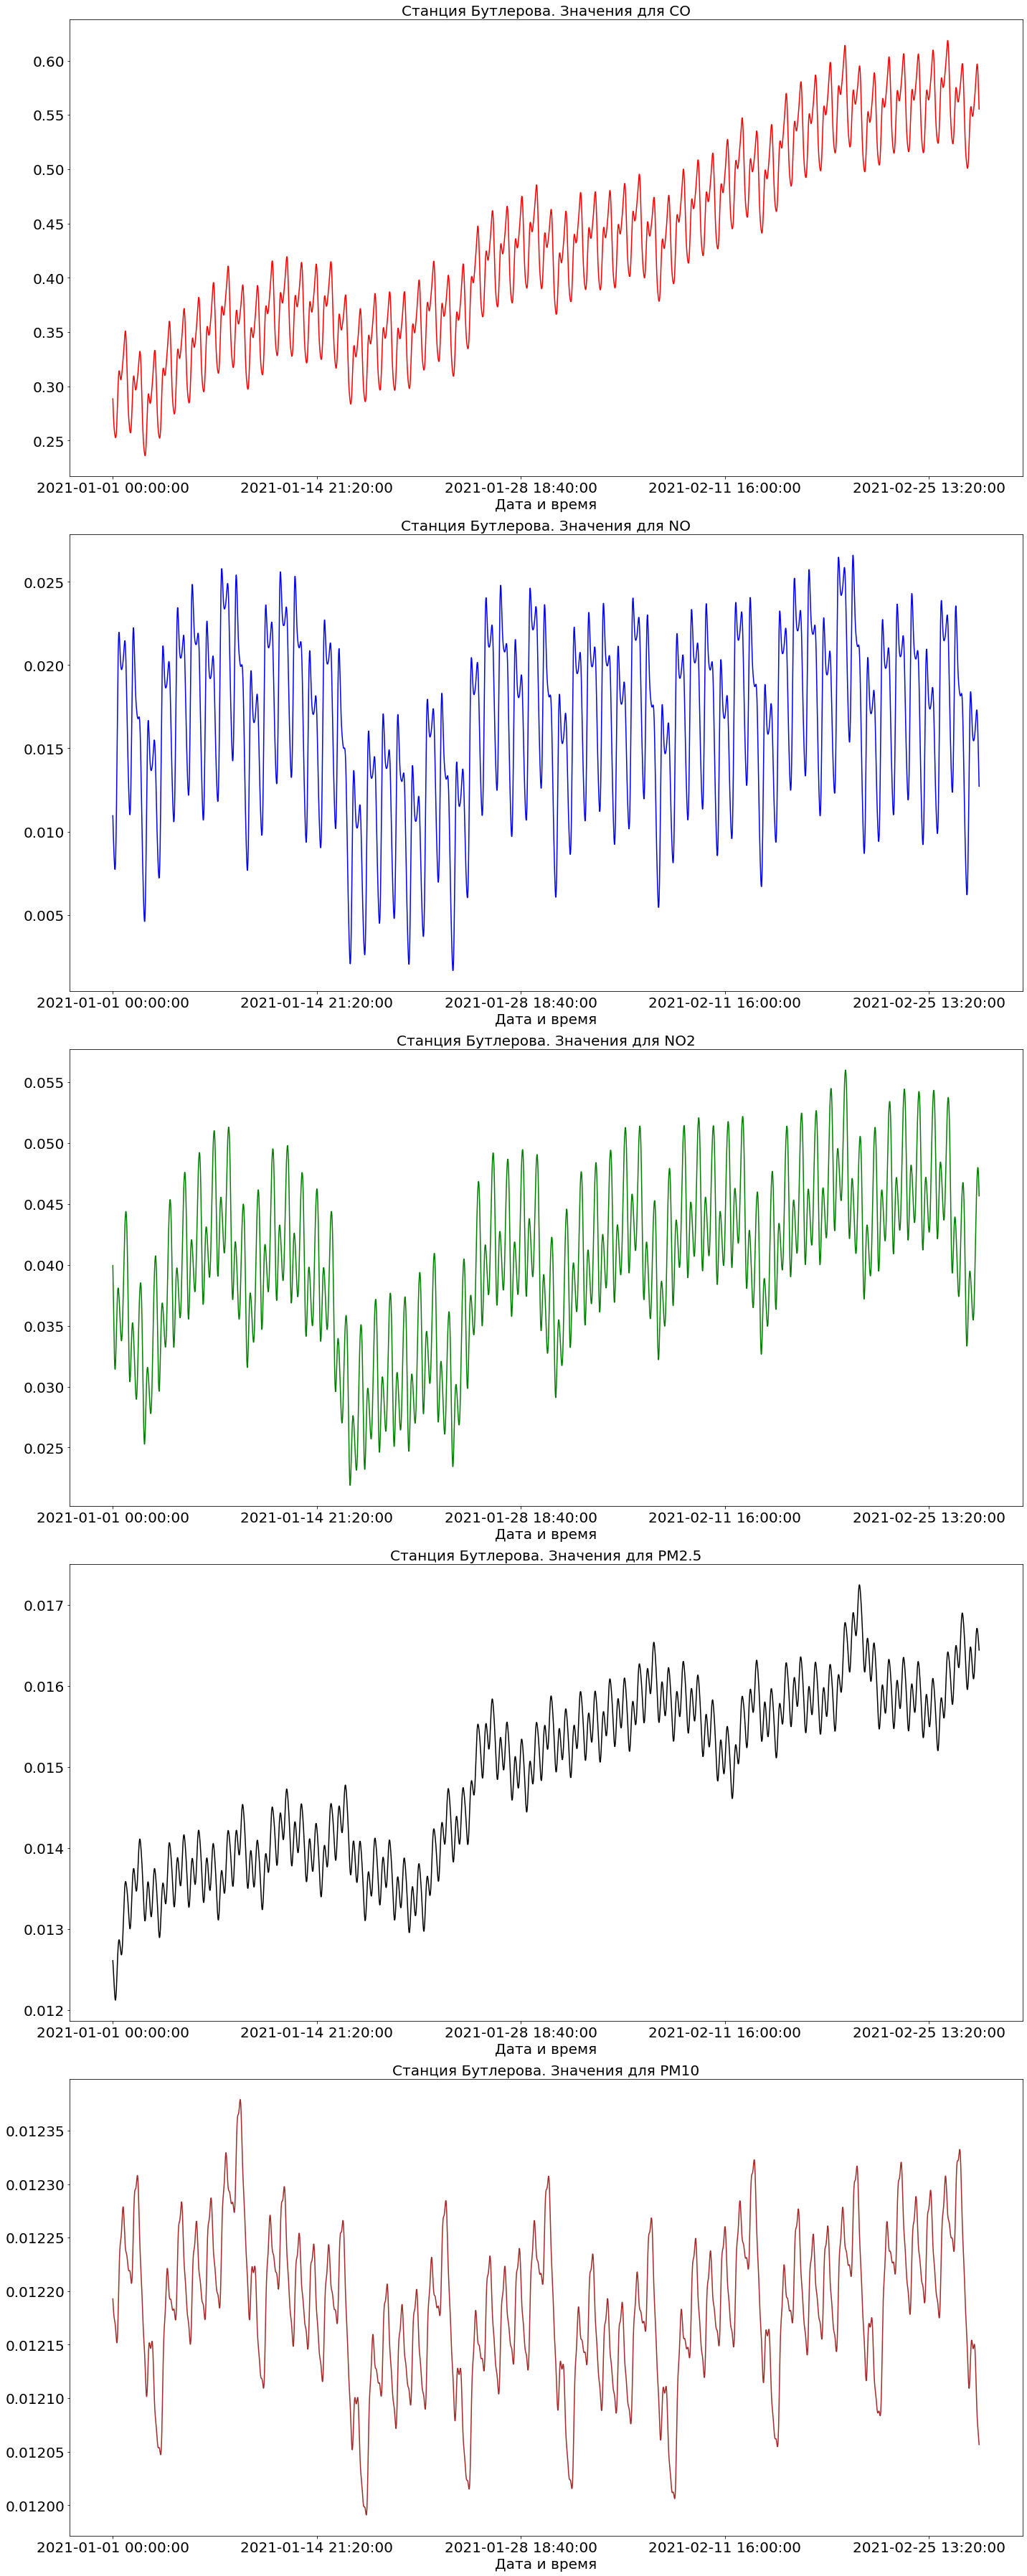

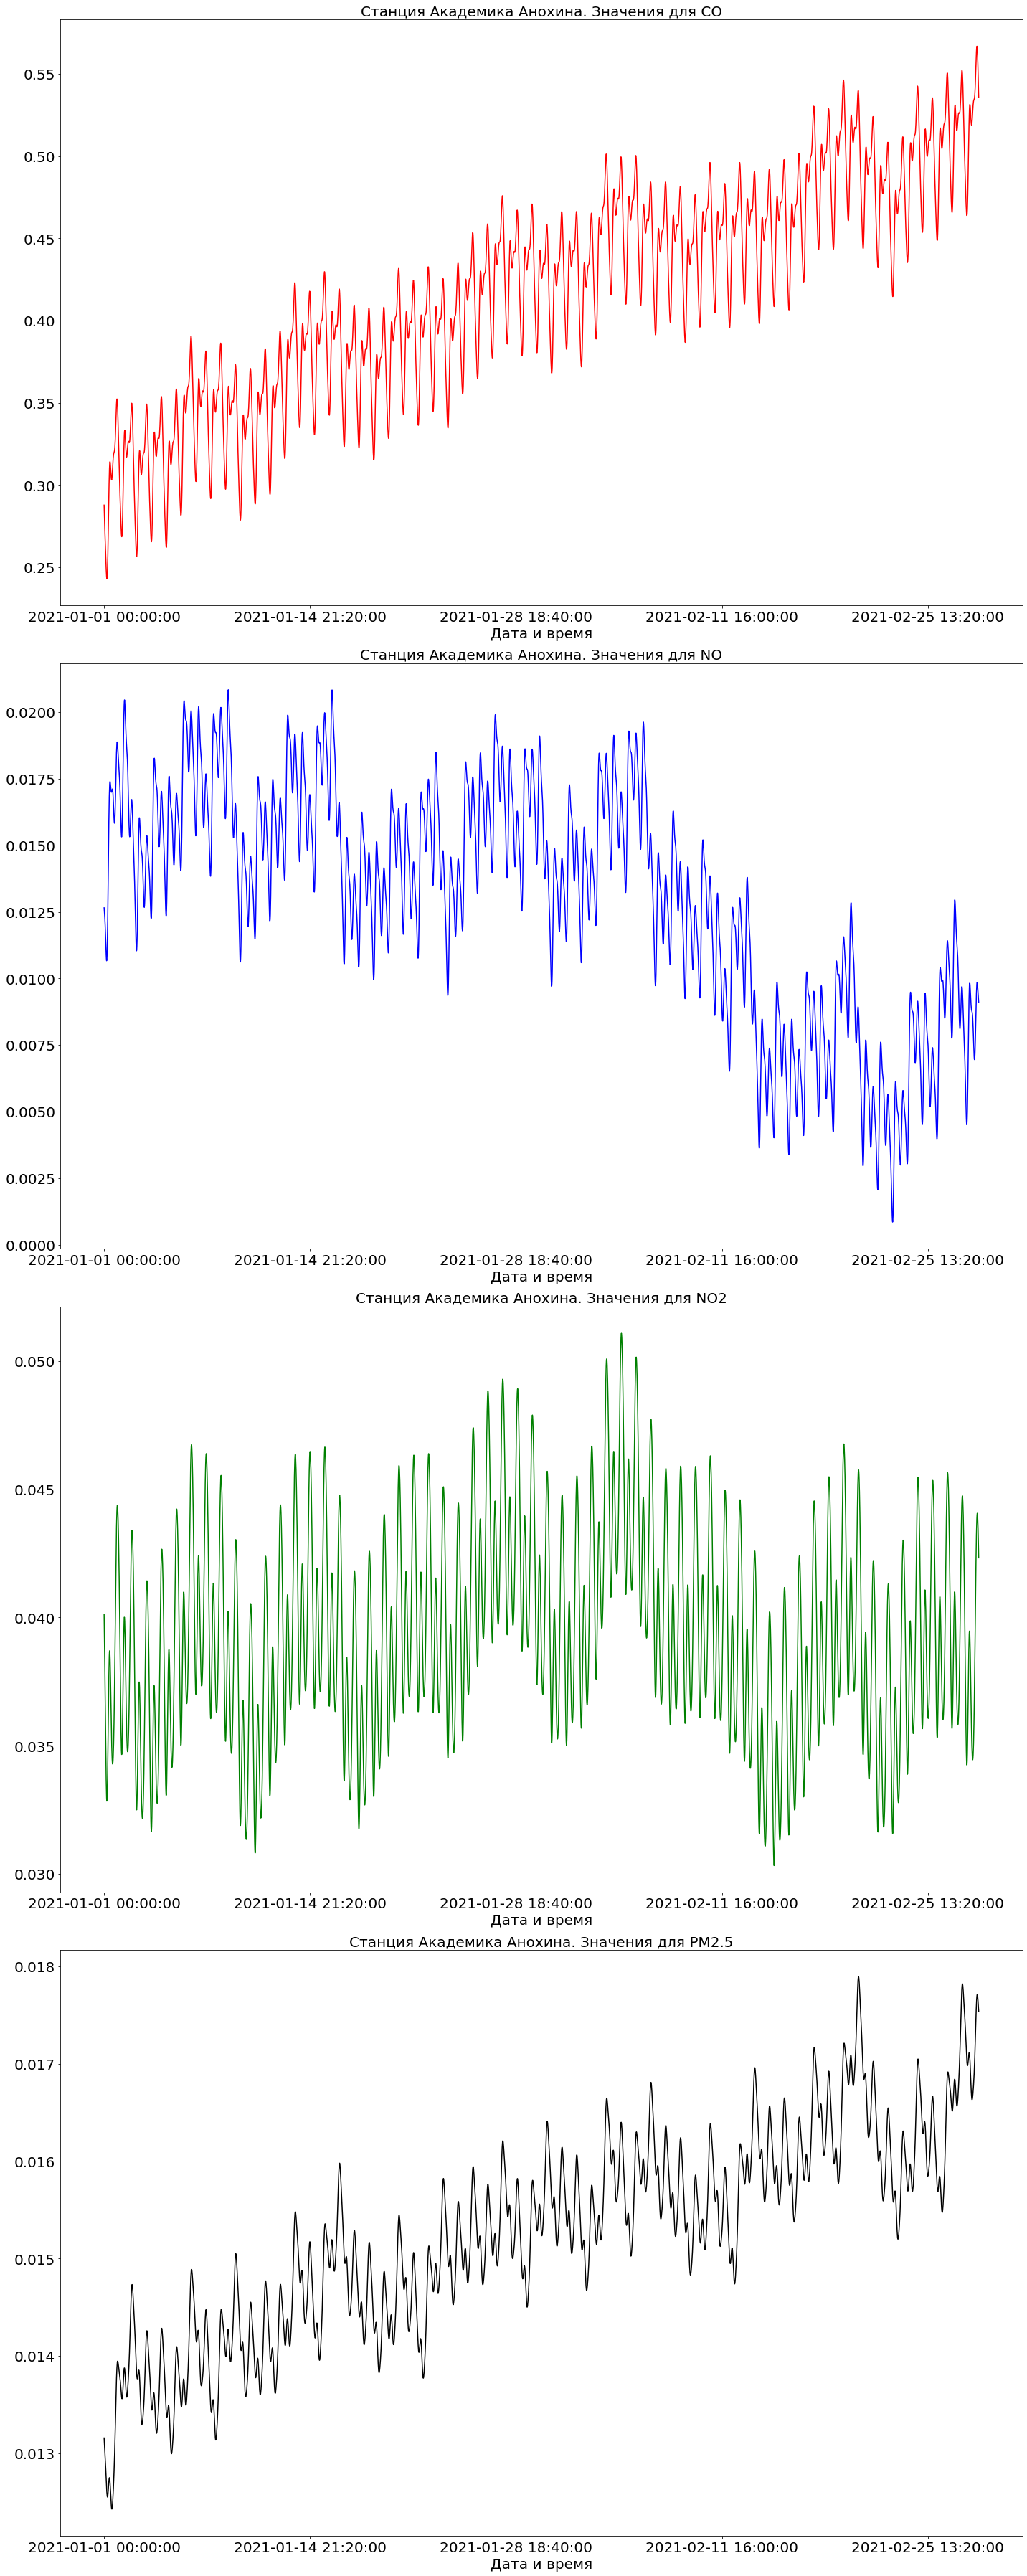

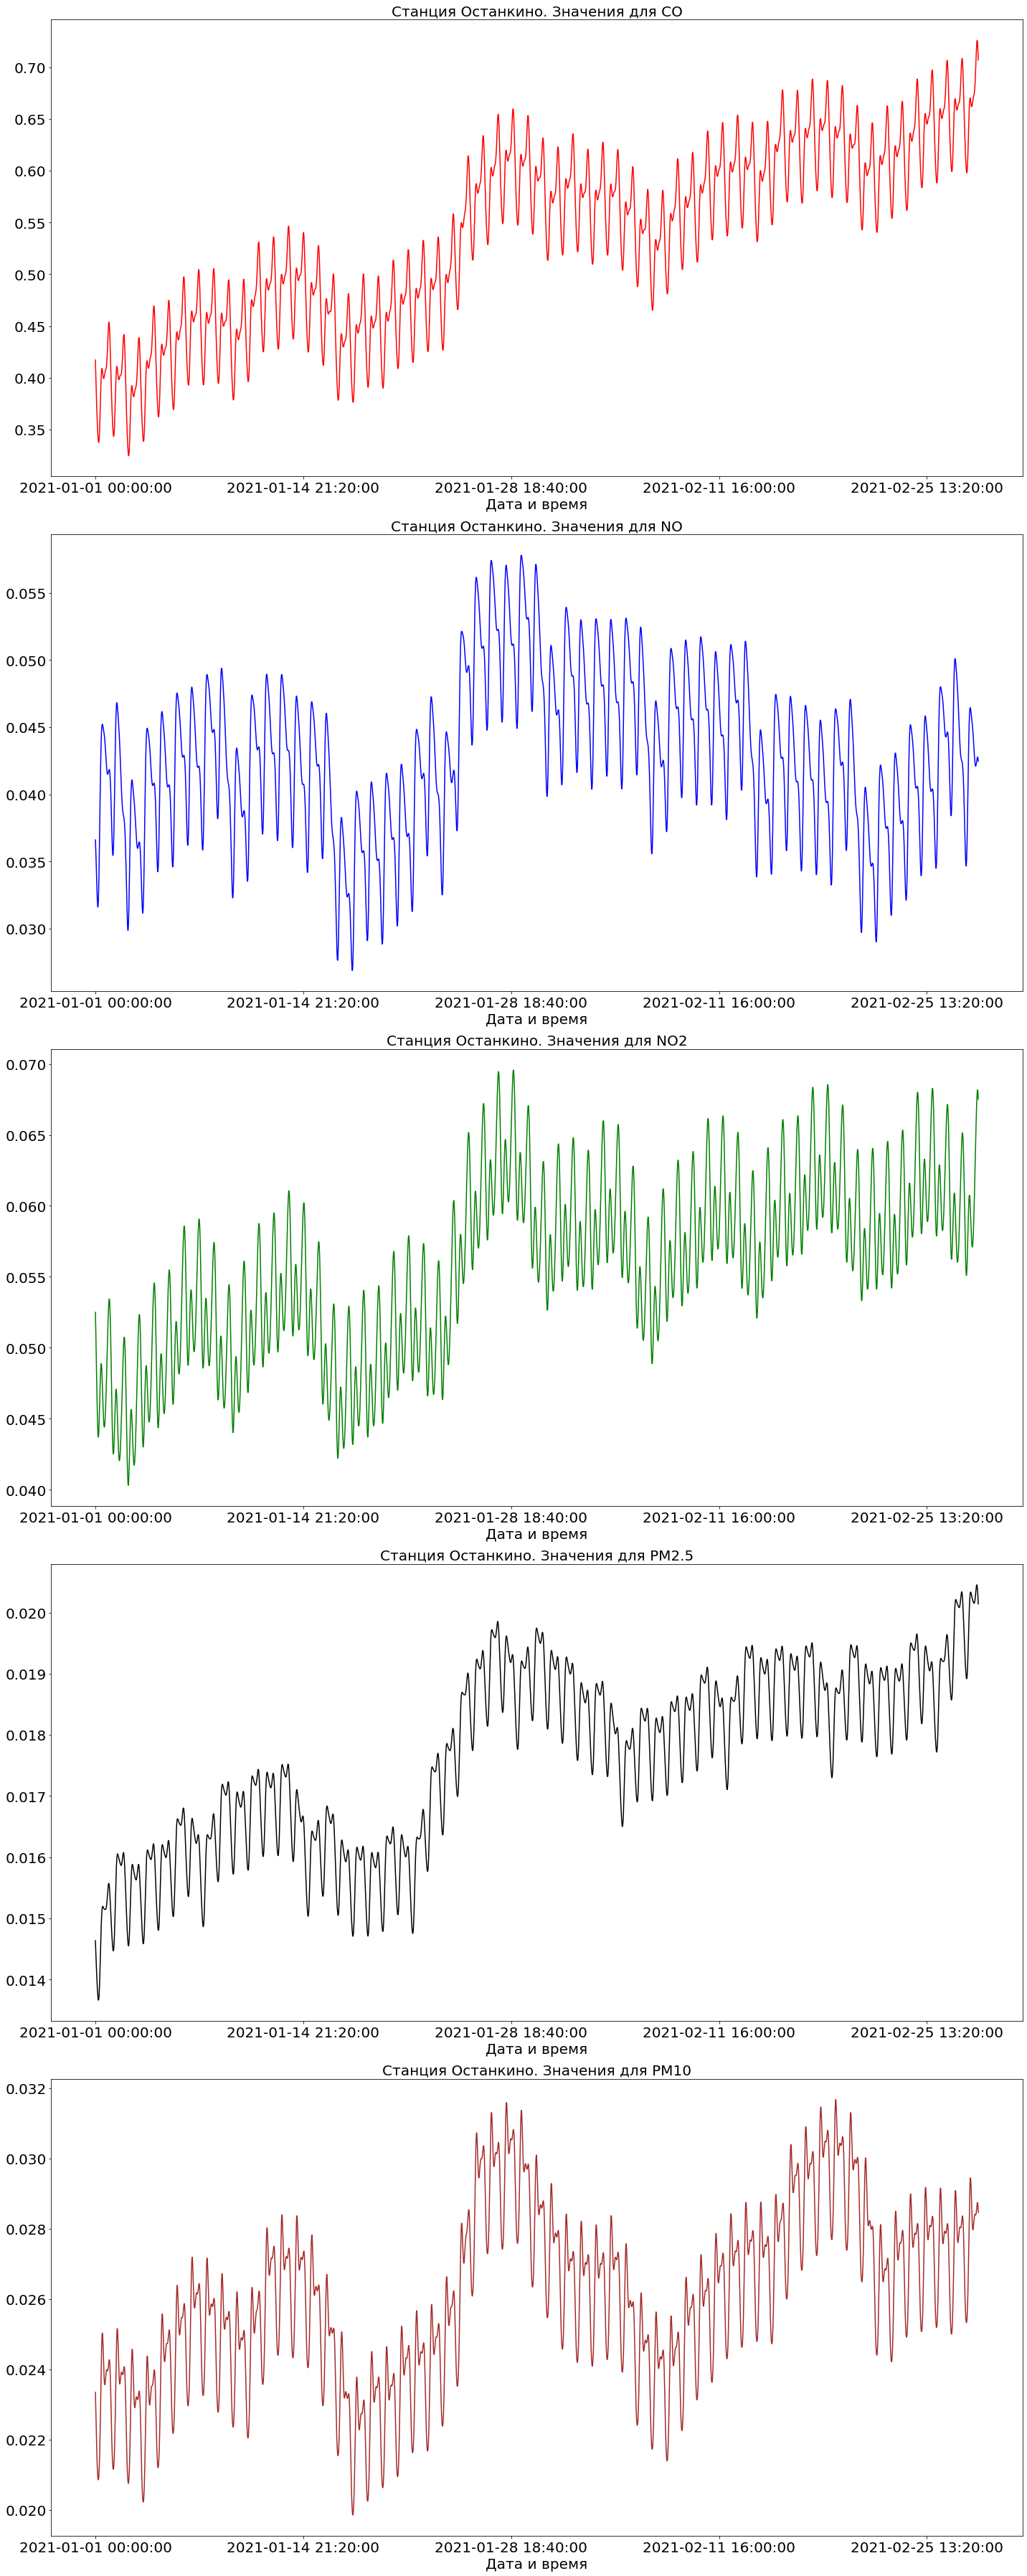

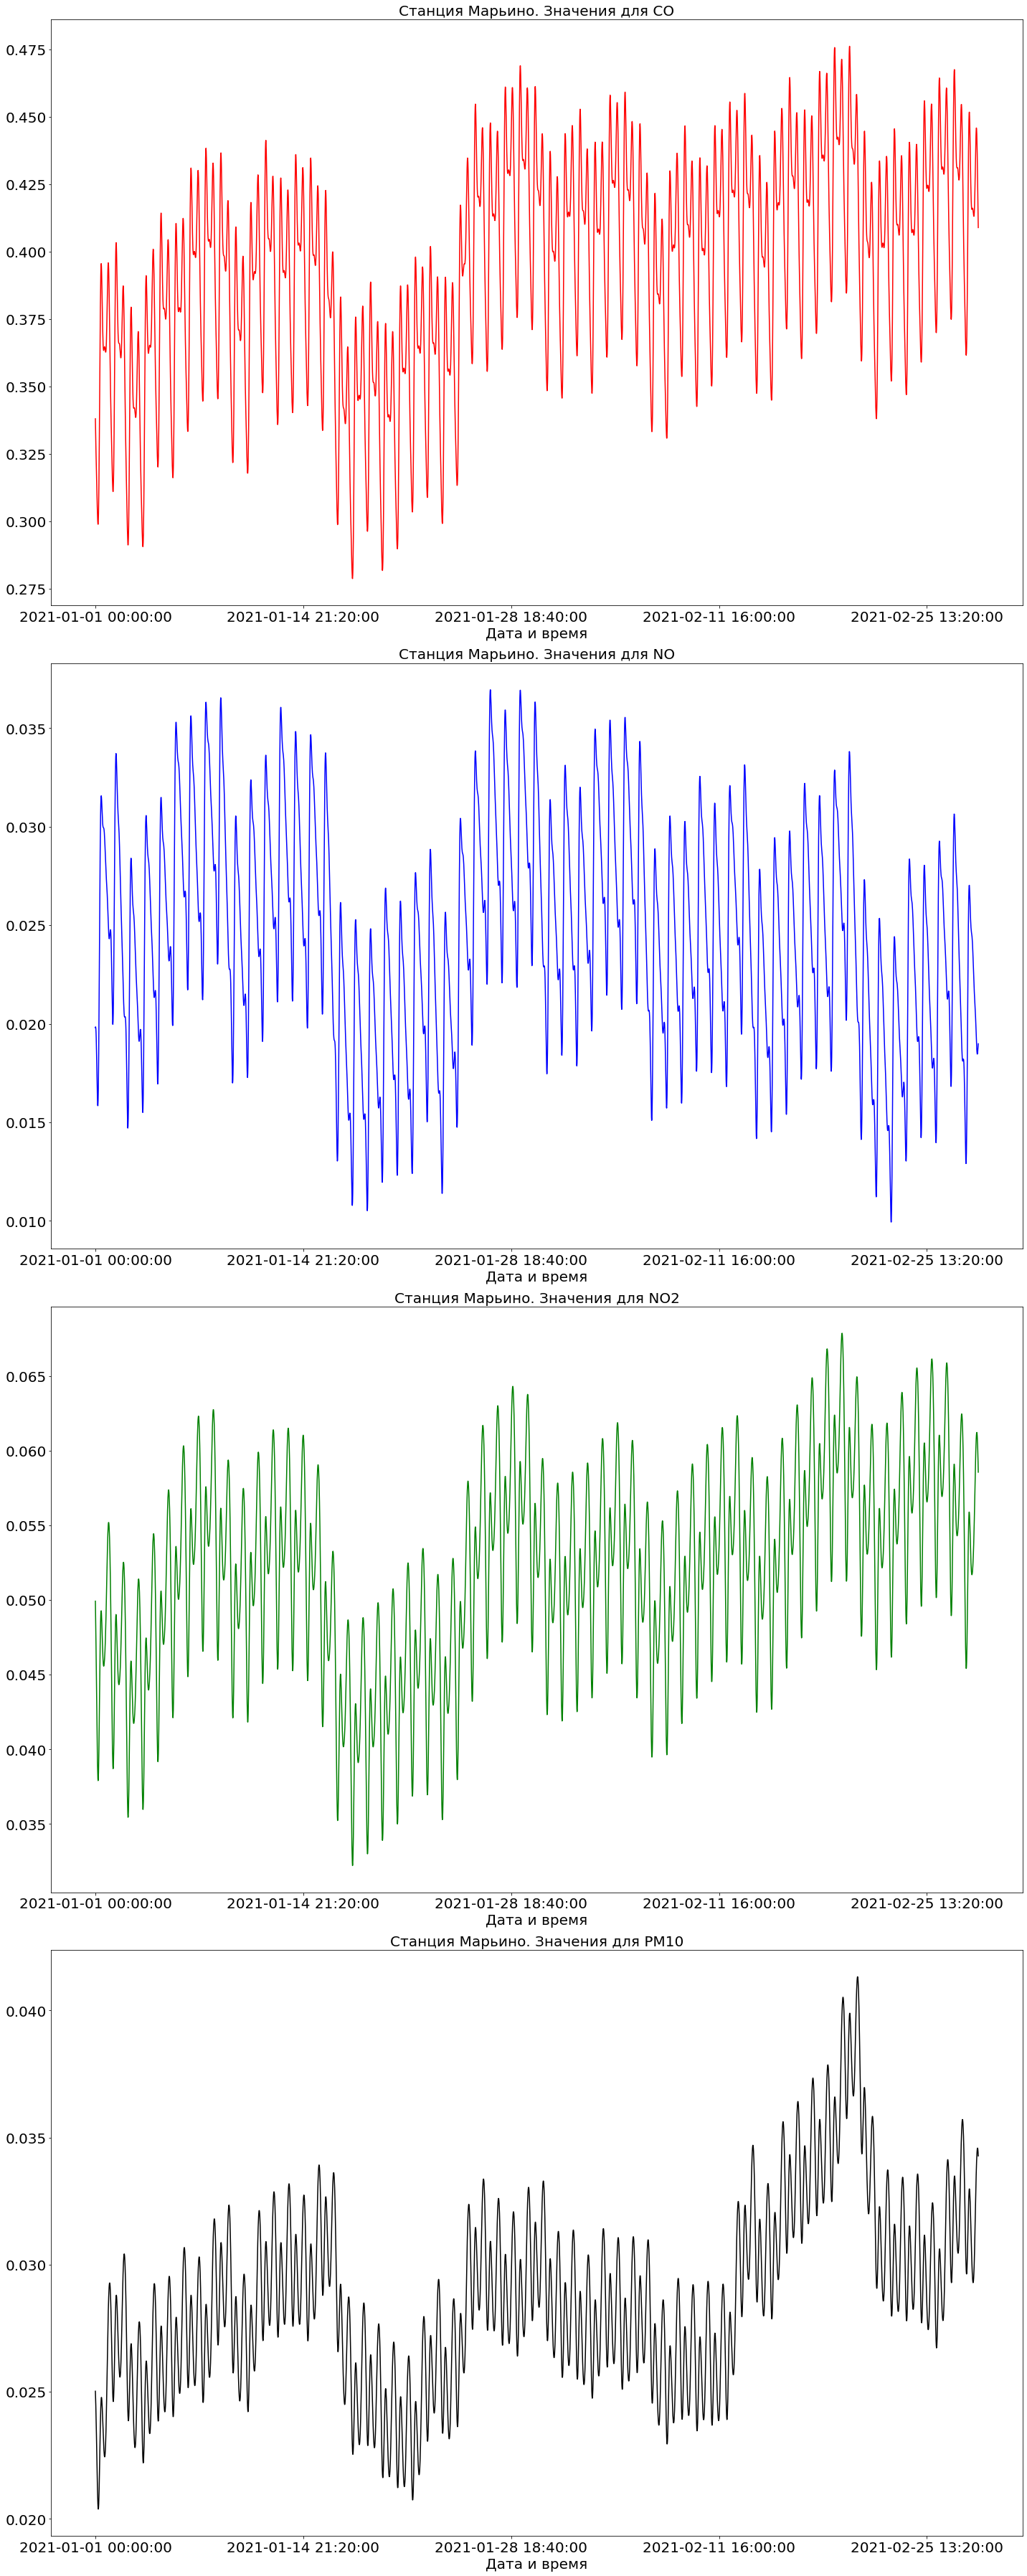

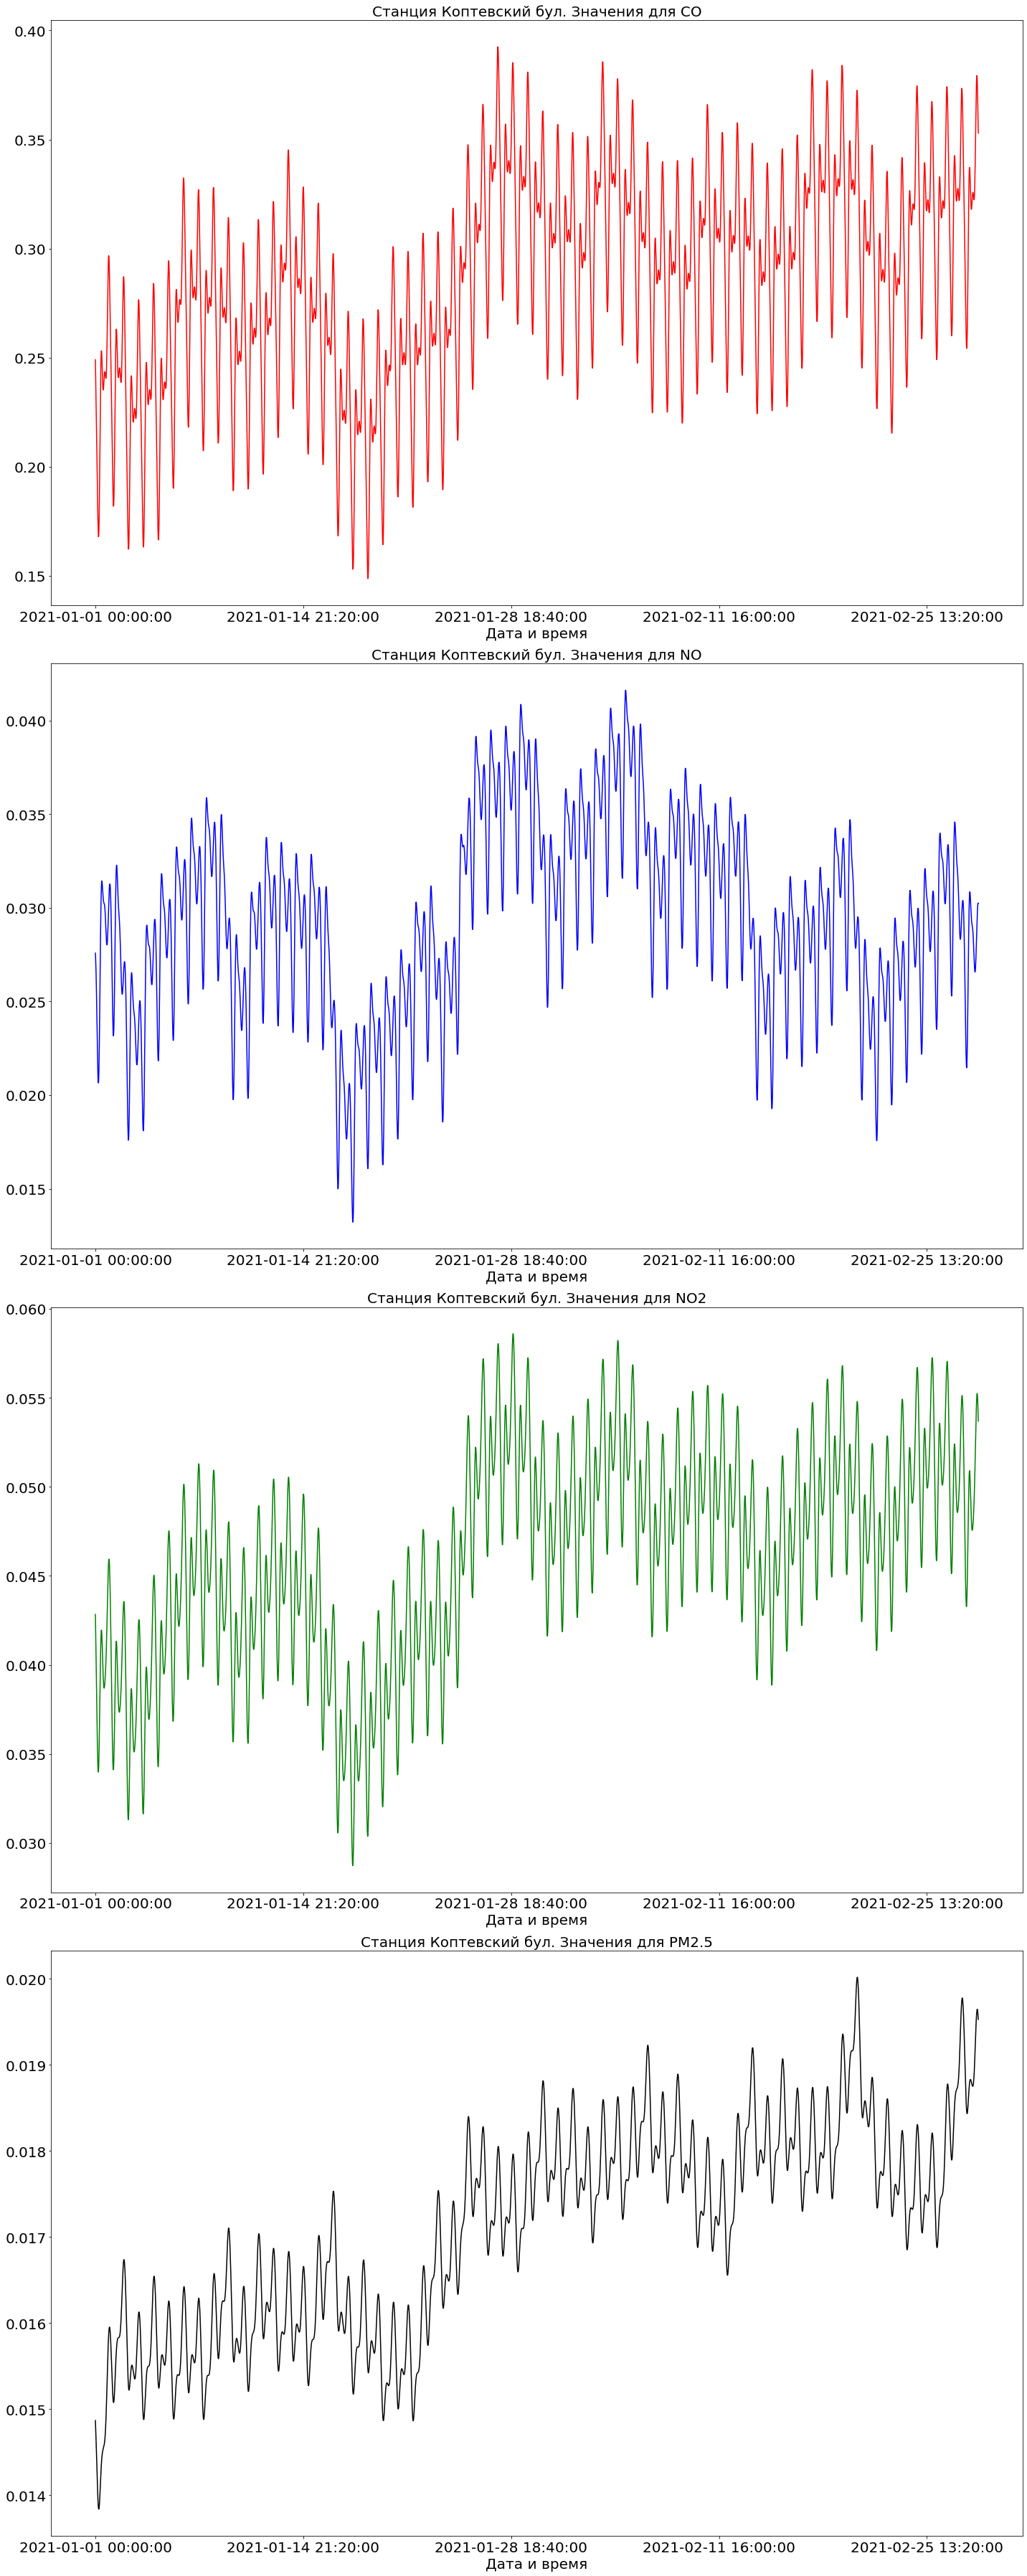

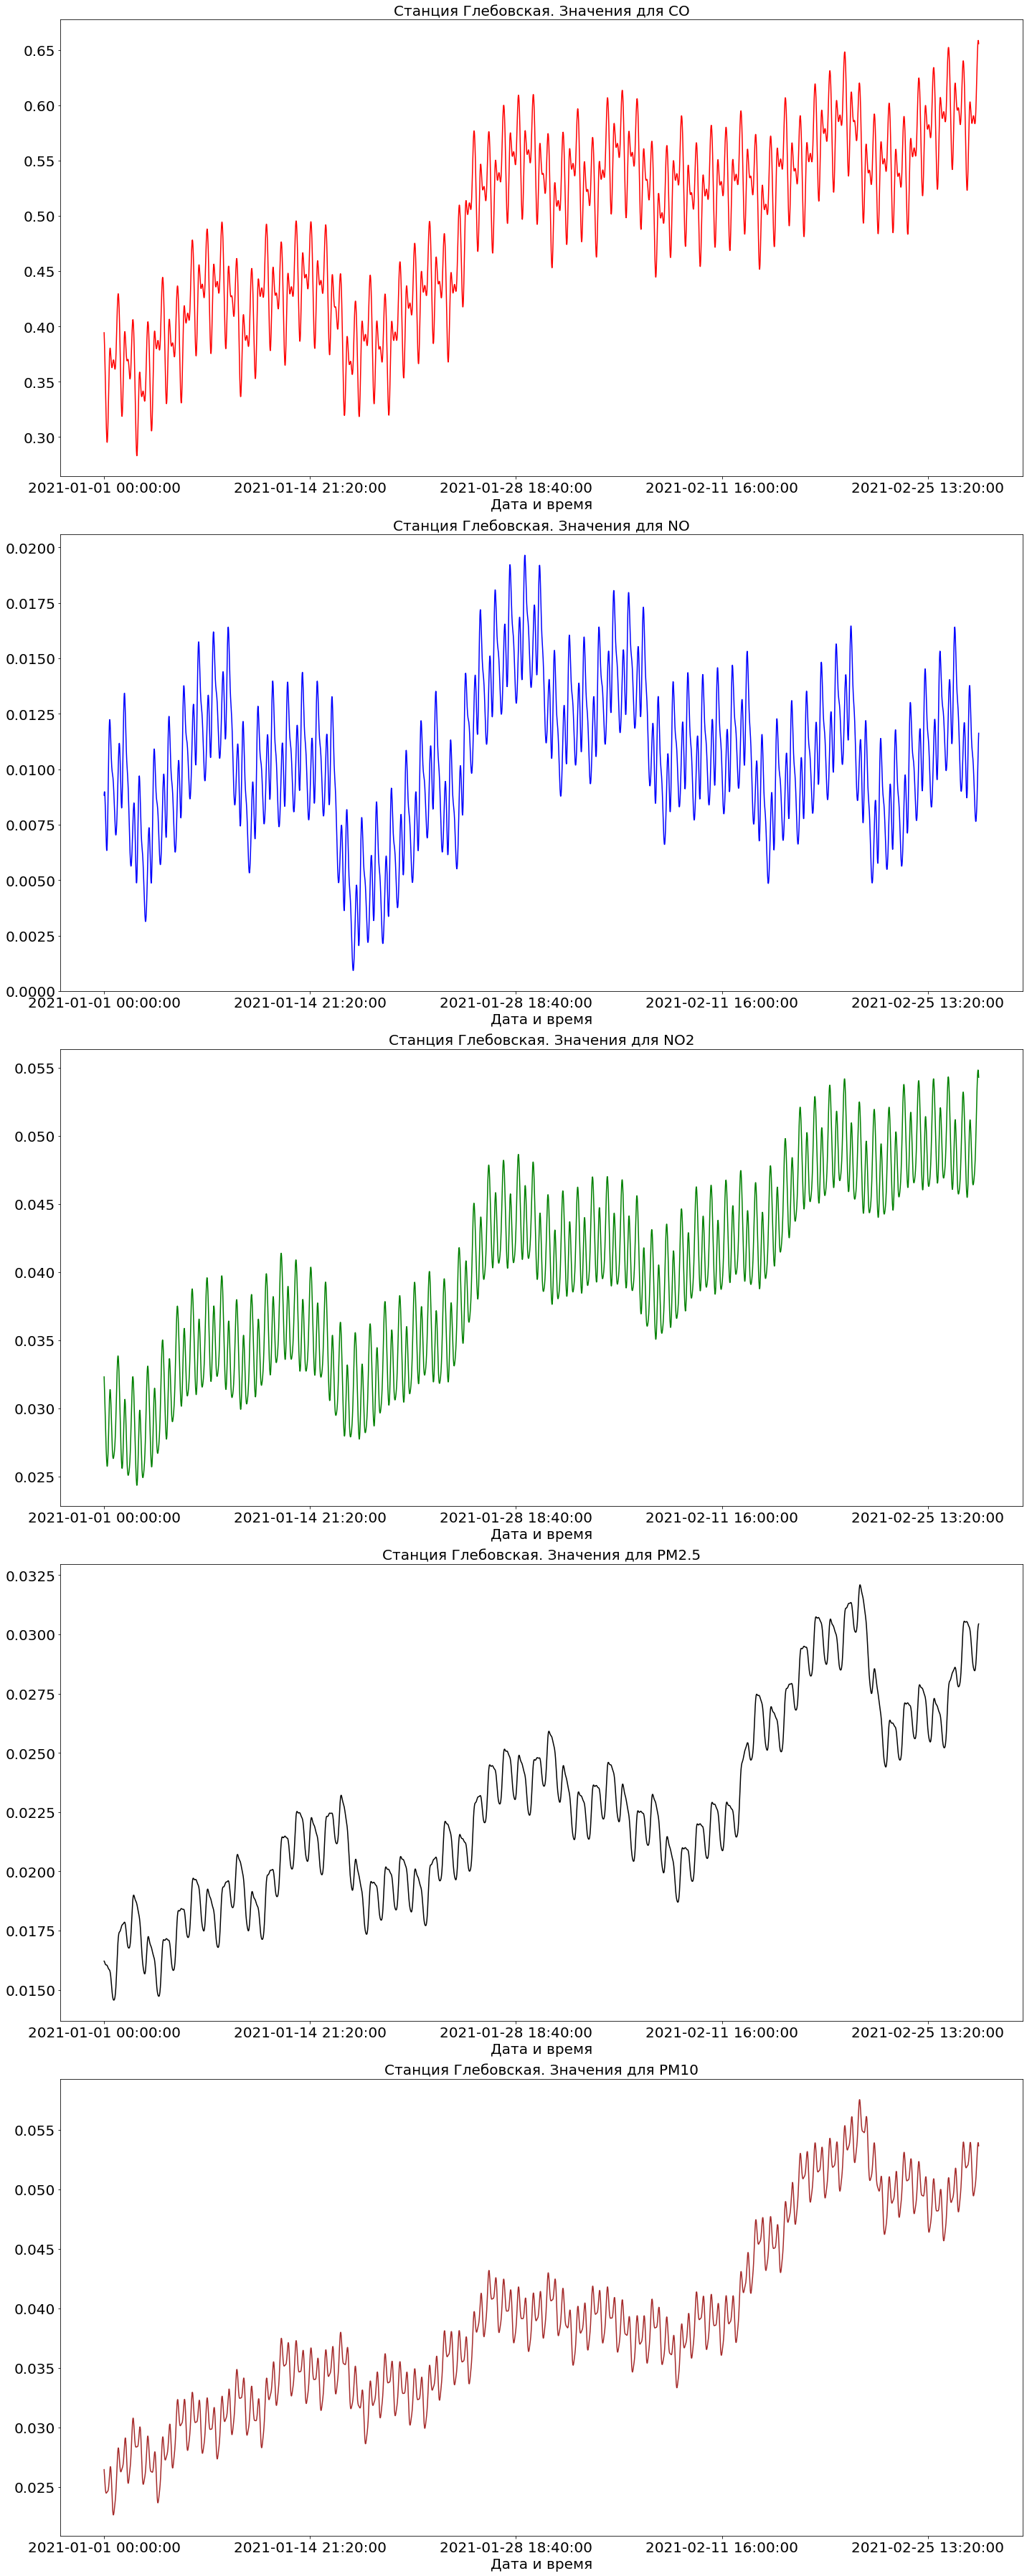

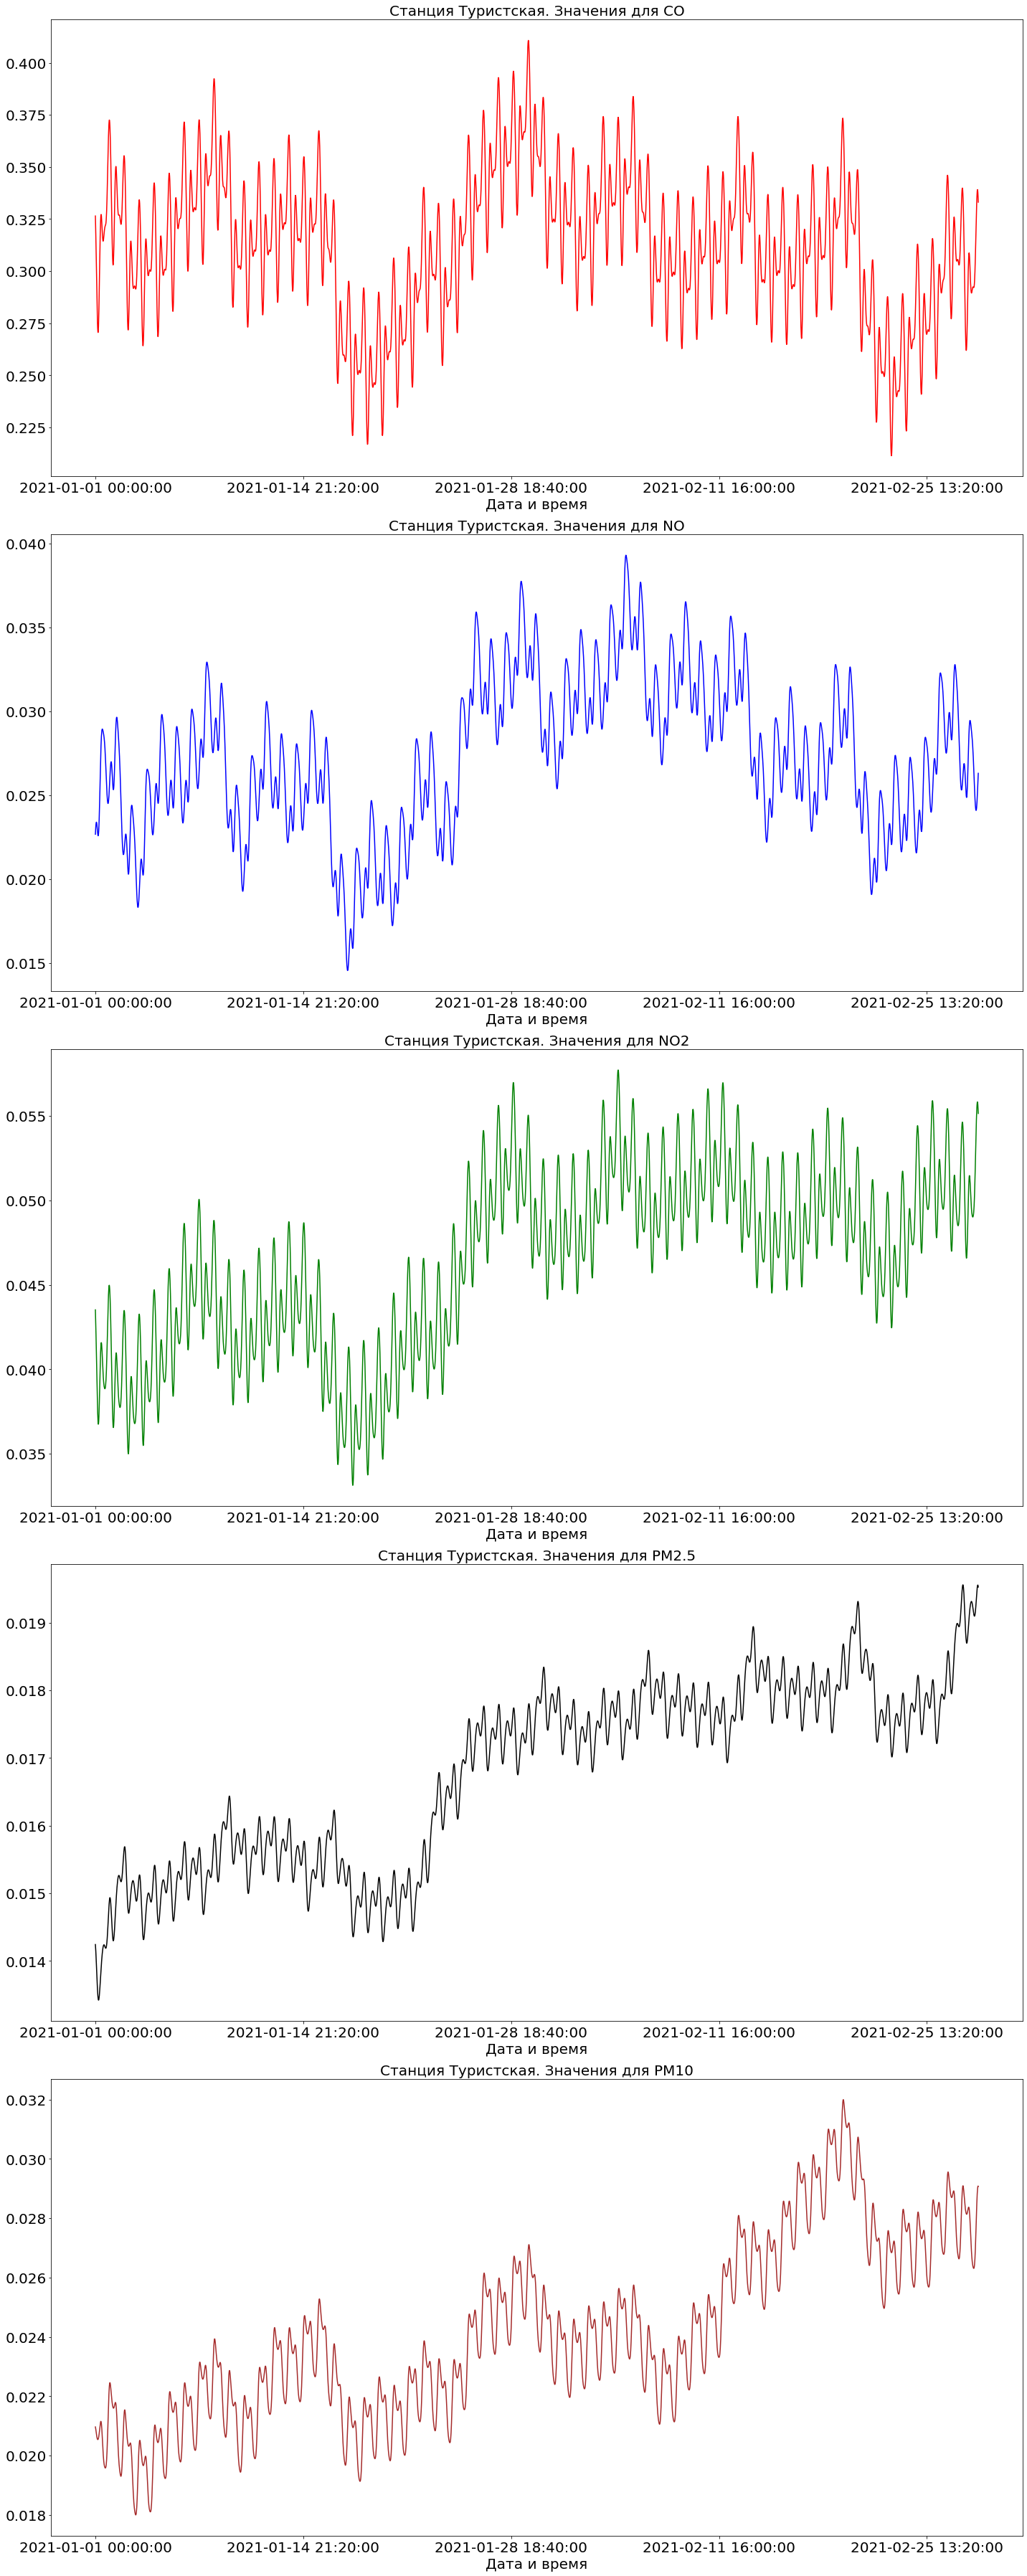

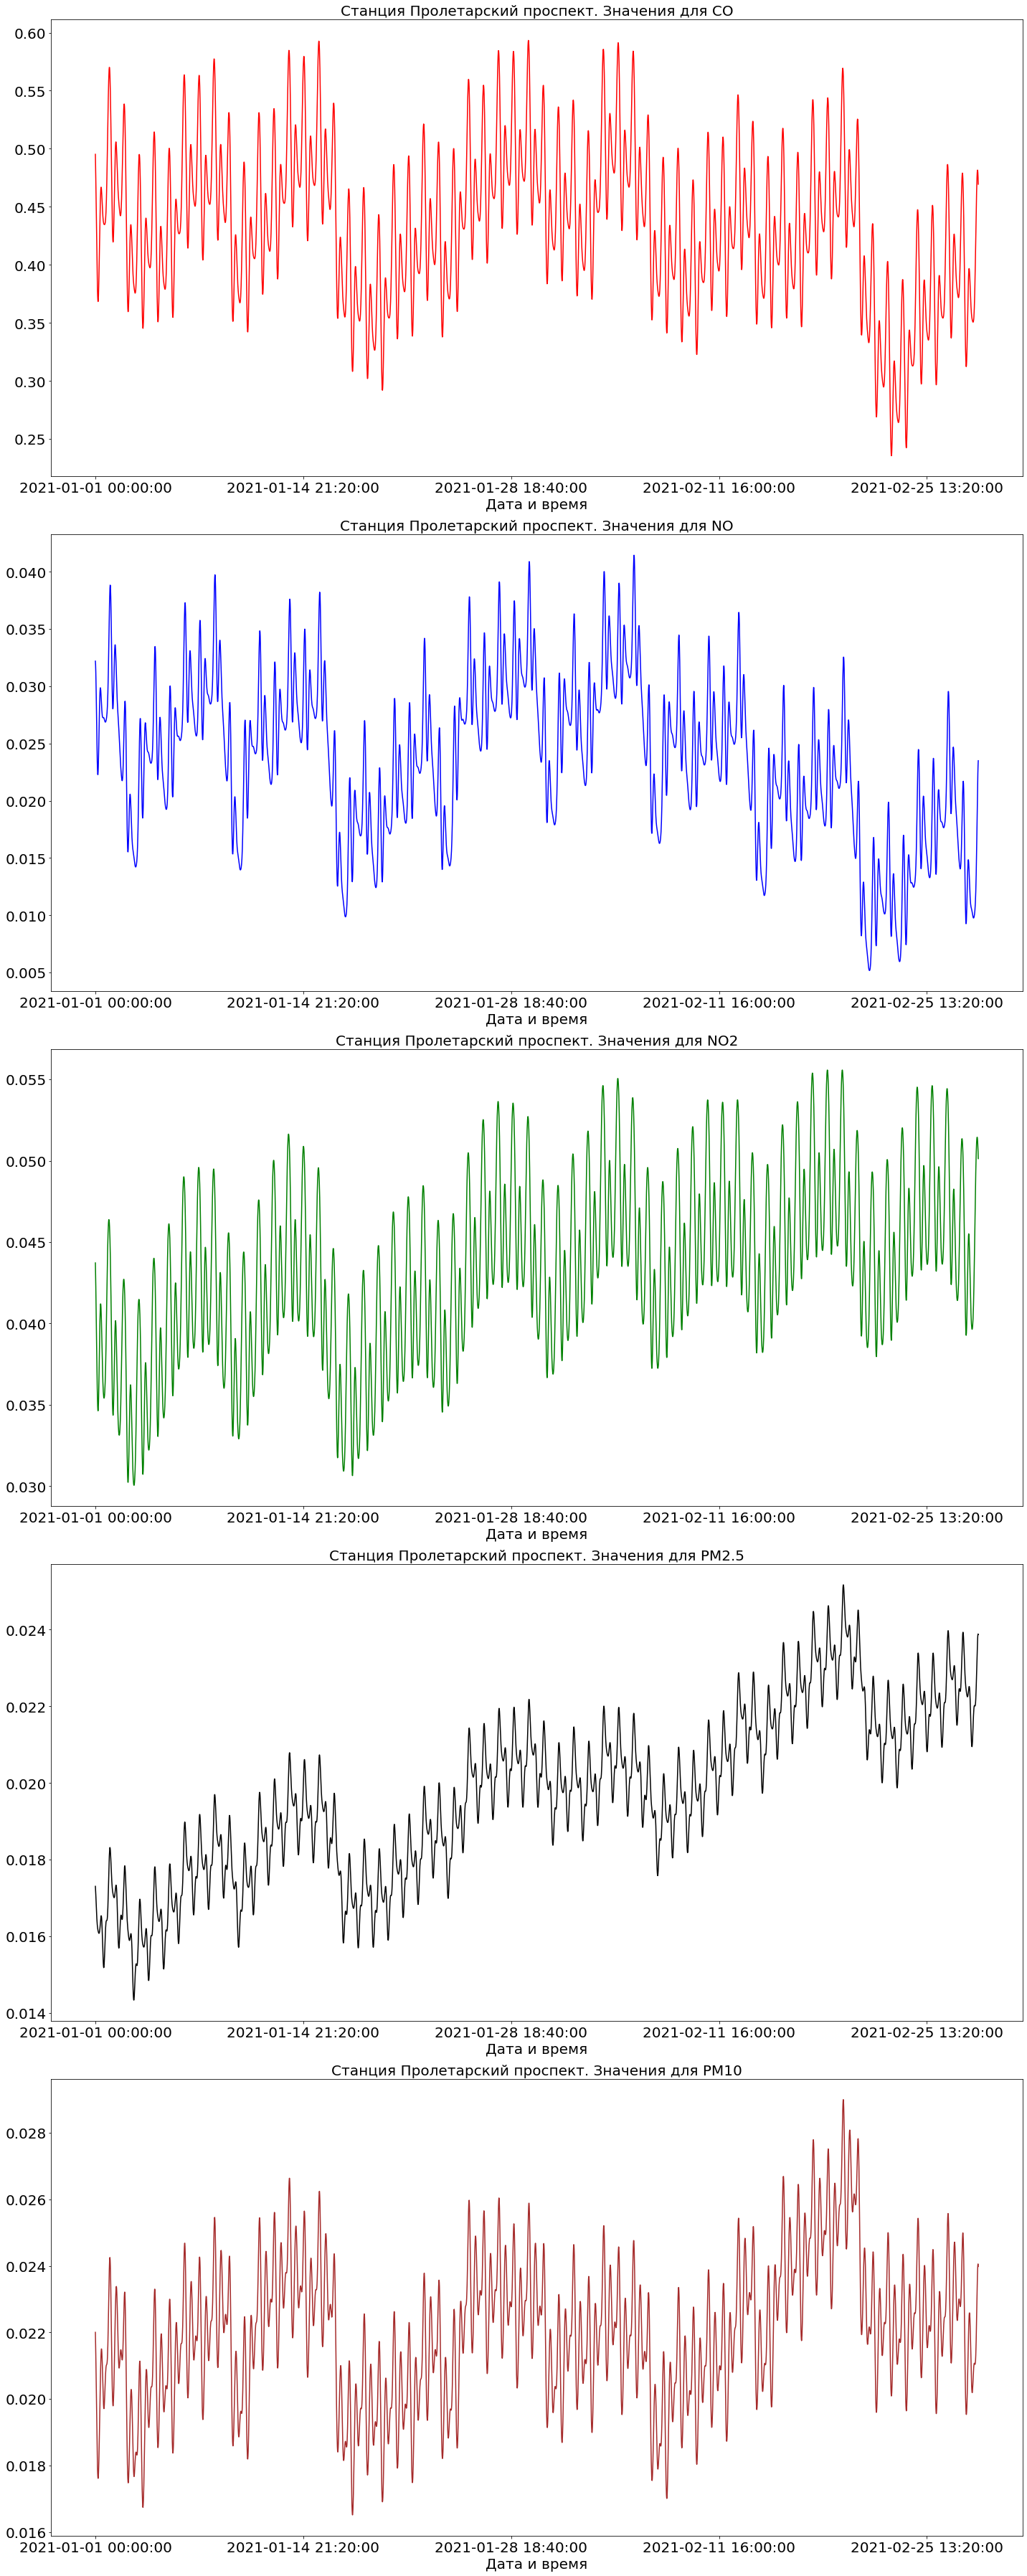

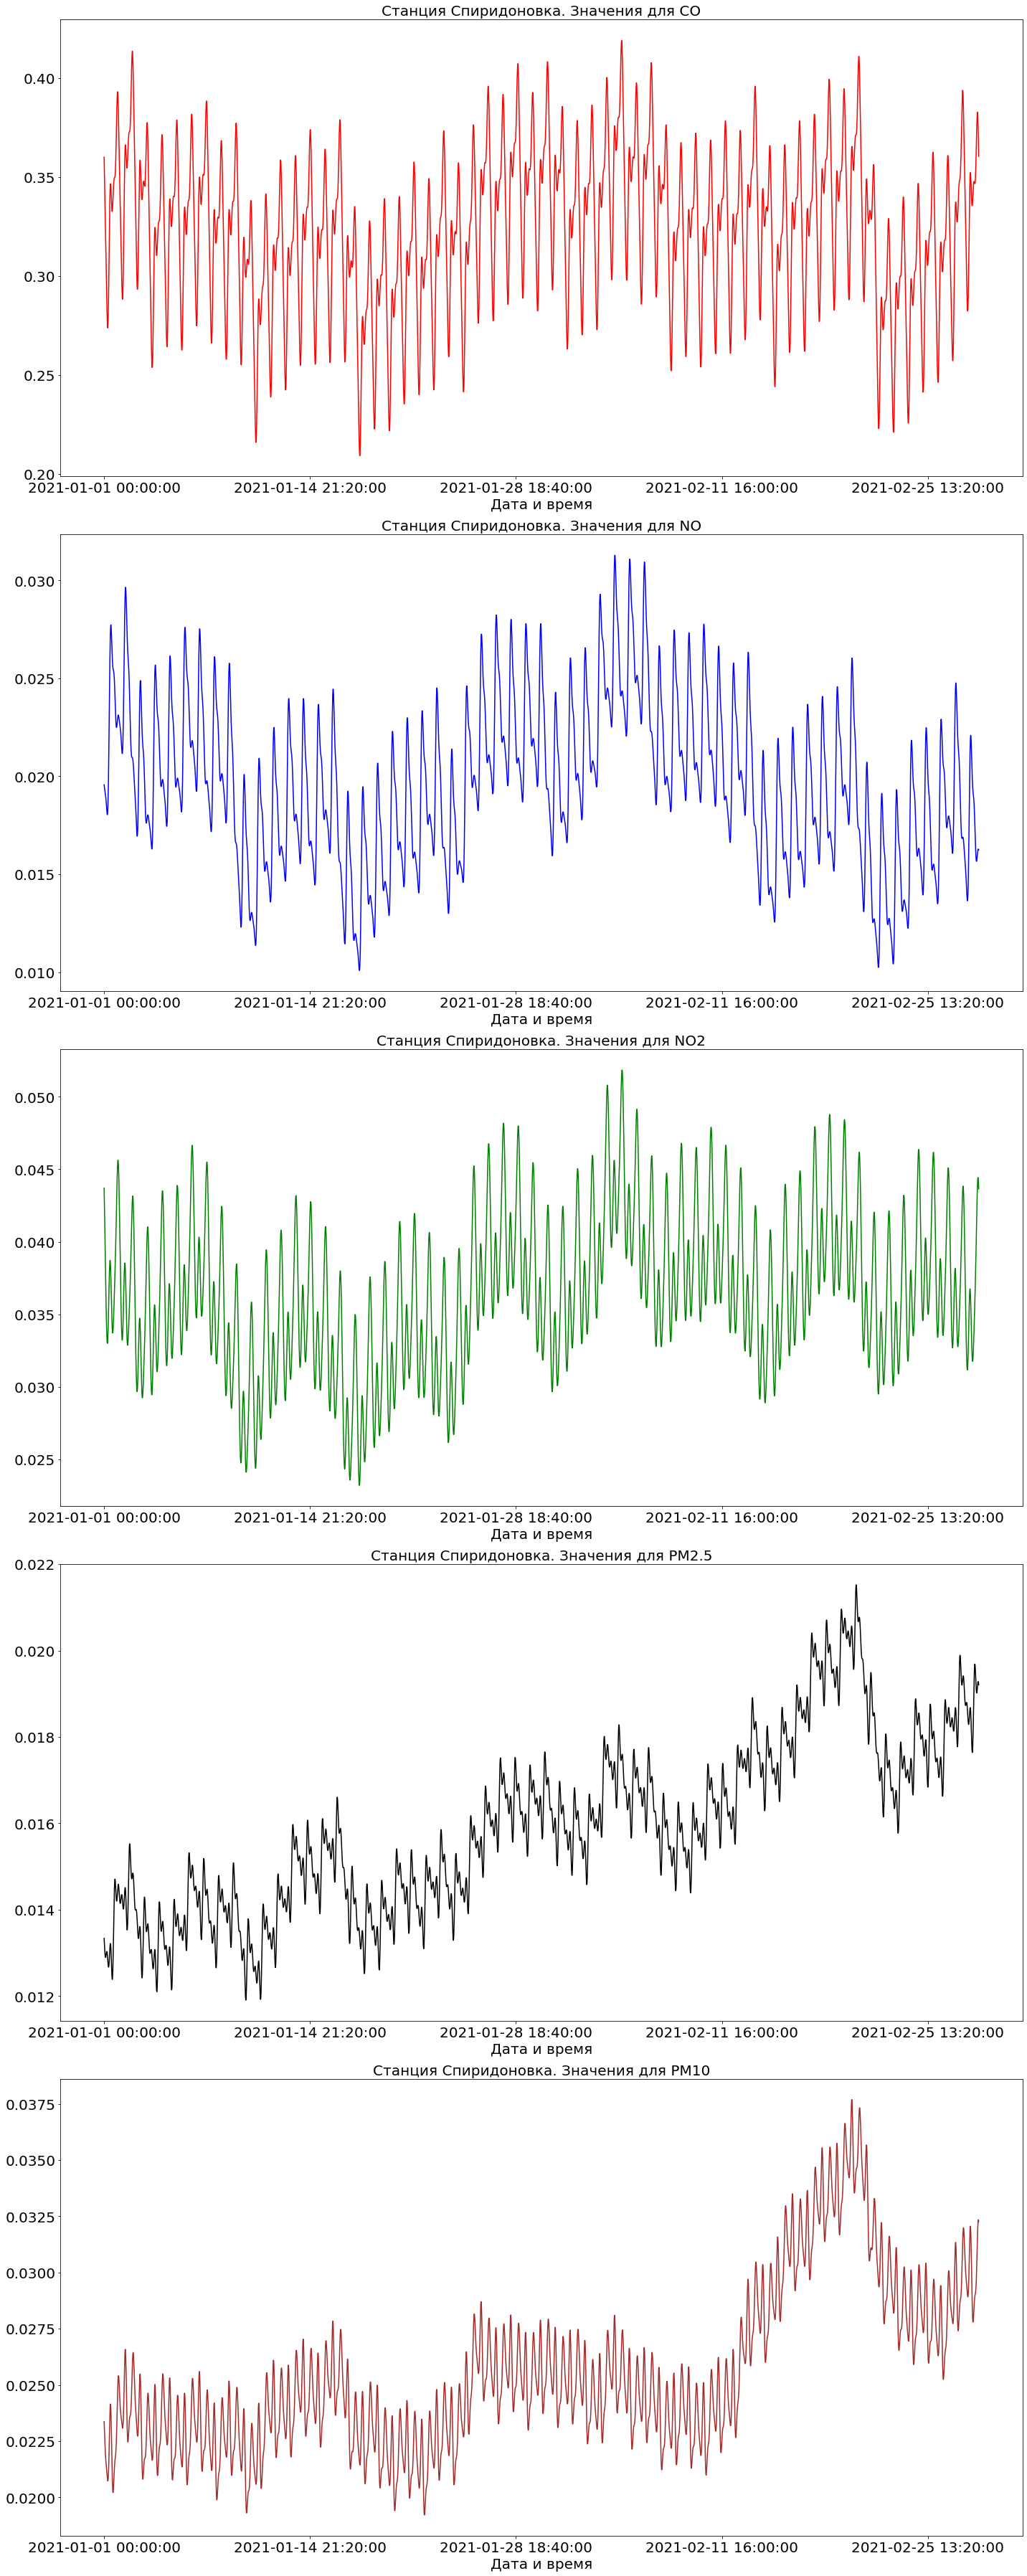

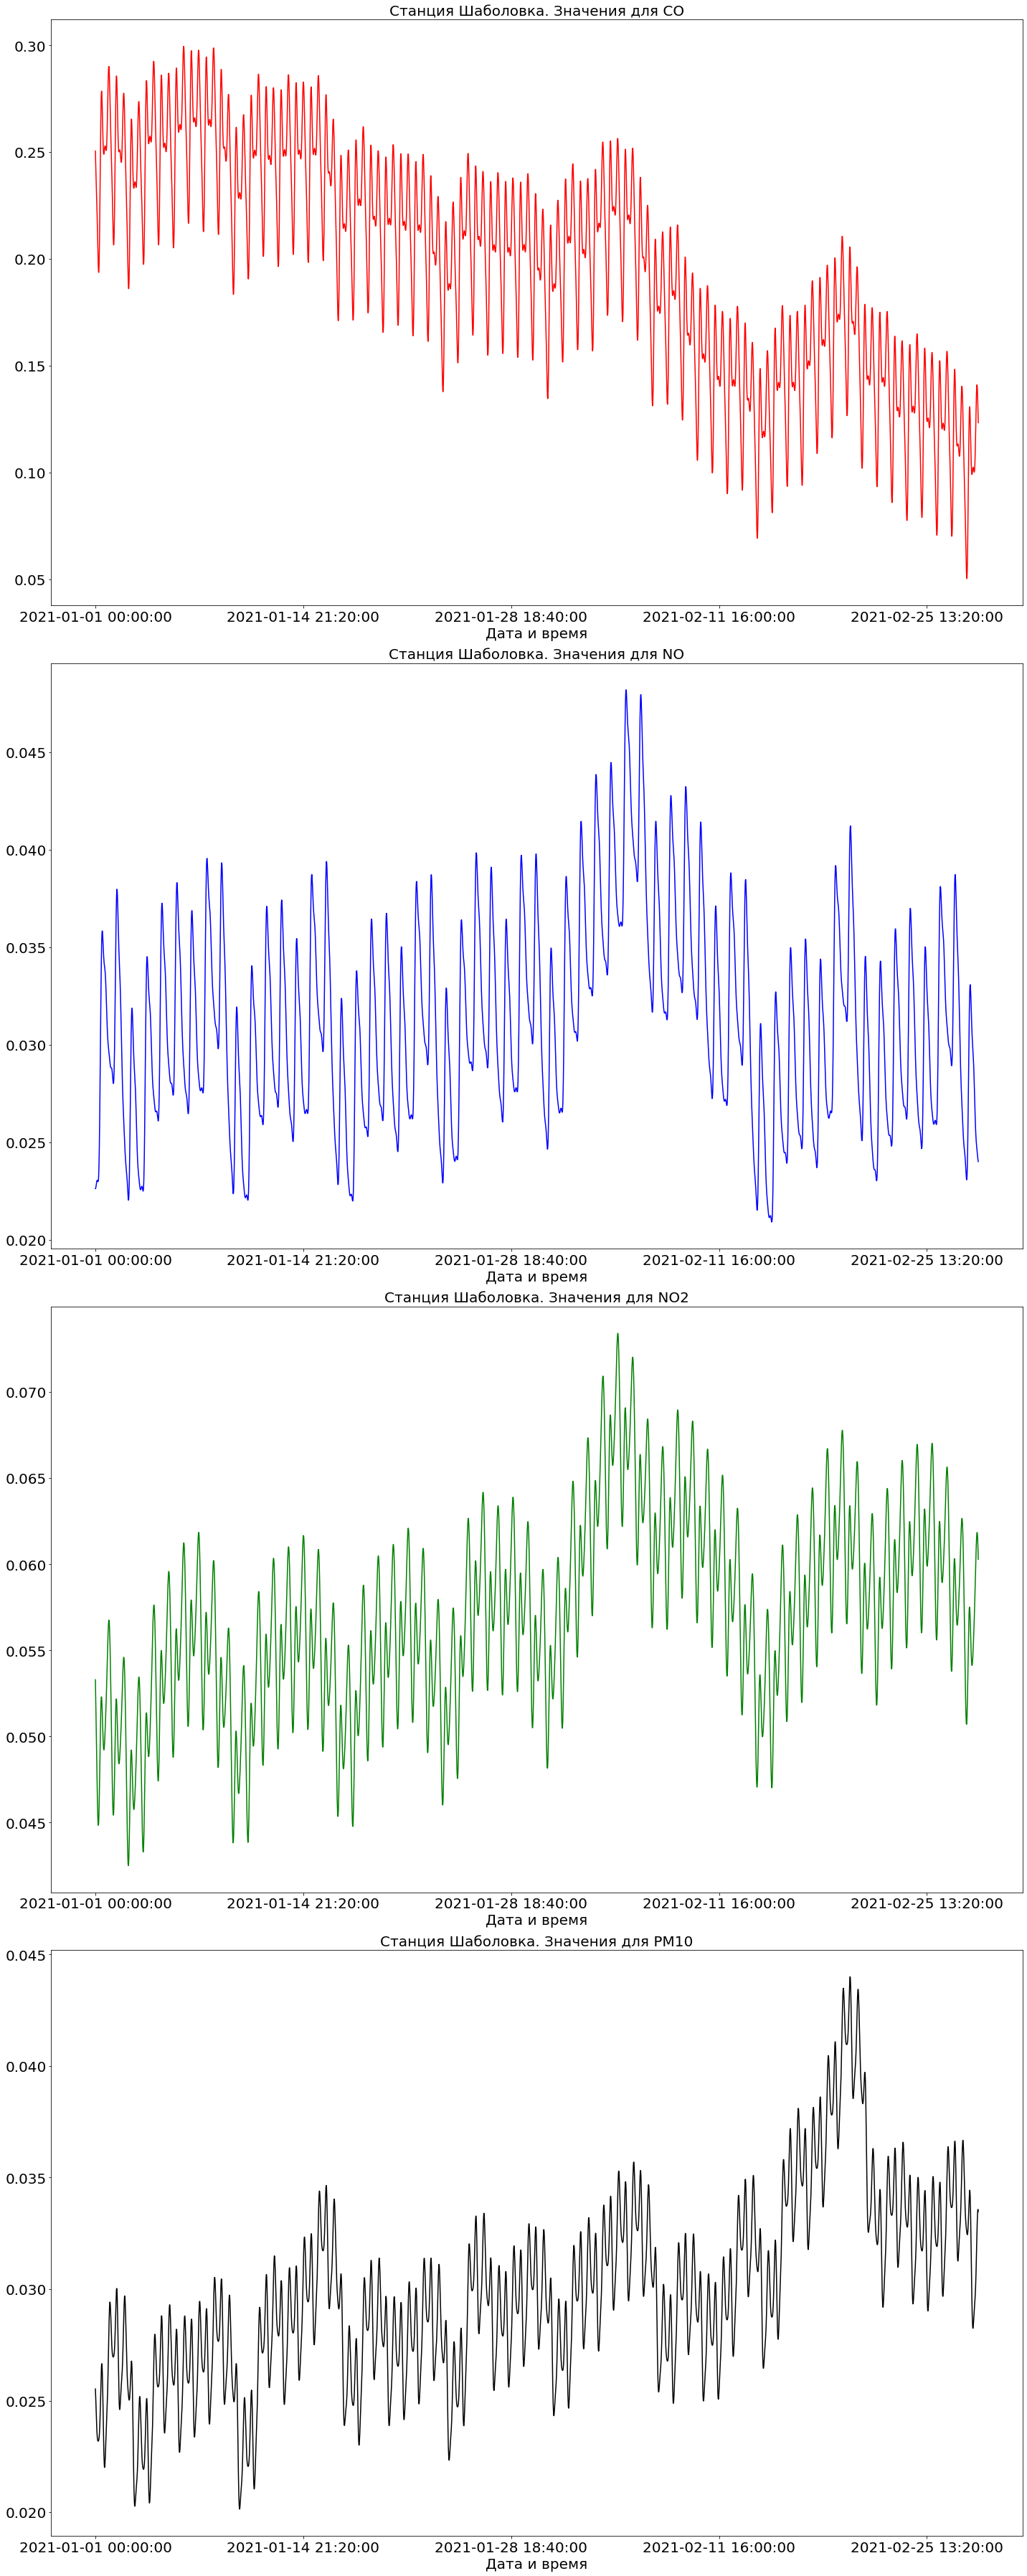

In [16]:
forecasts = []

# for csv_file in os.listdir(PROCESSED_DATA_FOLDER):
#     if csv_file != "combined_data.csv":
#         forecasts.append(make_prediction_file(csv_file))
        
for csv_file in os.listdir(RESULTS_FOLDER):
    name, ext = os.path.splitext(csv_file)
    
    if ext == ".csv":
        forecasts.append(pd.read_csv(os.path.join(RESULTS_FOLDER, csv_file)))

for i in range(len(forecasts)):
#     forecasts[i].set_index('ds').to_csv(os.path.join(RESULTS_FOLDER, f'{STATION_NAMES[i]}.csv'))
    plot_forecast(forecasts[i], i)

In [ ]:
# def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
#     n_vars = 1 if type(data) is list else data.shape[1]
#     df = pd.DataFrame(data)
#     cols, names = list(), list()
#     # input sequence (t-n, ... t-1)
#     for i in range(n_in, 0, -1):
#         cols.append(df.shift(i))
#         names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
#     # forecast sequence (t, t+1, ... t+n)
#     for i in range(0, n_out):
#         cols.append(df.shift(-i))
#         if i == 0:
#             names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
#         else:
#             names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
#     # put it all together
#     agg = pd.concat(cols, axis=1)
#     agg.columns = names
#     # drop rows with NaN values
#     if dropnan:
#         agg.dropna(inplace=True)
#     return agg

In [ ]:
# values = df.values.astype('float32')

# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled = scaler.fit_transform(values)
# reframed = series_to_supervised(scaled, 1, 1)

# reframed.head()

In [ ]:
# values = reframed.values
# n_train_hours = 330 * 24 * 3
# train = values[:n_train_hours, :]
# test = values[n_train_hours:, :]
# # split into input and outputs
# train_X, train_y = train[:, :-10], train[:, -10:]
# test_X, test_y = test[:, :-10], test[:, -10:]
# # reshape input to be 3D [samples, timesteps, features]
# train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
# test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
# print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)